In [10]:
pwd

'/Users/maruyamakouta/Downloads'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import networkx as nx
import MeCab
from collections import defaultdict, Counter
from copy import copy, deepcopy
mecab = MeCab.Tagger('-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd')
mecab.parse('')

'EOS\n'

In [4]:
node_name = defaultdict(str)
node_idx = defaultdict(int)
node_type = defaultdict(list)
node_count = defaultdict(int)
edge_list = []
with open('sample3.txt', encoding='utf-8',mode="r") as f:
    lines=f.readlines()
    stopwords=['ここ', 'あれ','ん','よう','0','こと','さん','の', 'ん','これ','もの','そう']

In [5]:
cnt = 0
for line in lines:
    node = mecab.parseToNode(line)
    node_prev = None
    while node:
        w = node.surface
        w_type = node.feature.split(',')[0]
        if (w_type in ["名詞", "動詞", "形容詞"]) & (w not in stopwords):
            # Nodeの処理
            if w not in node_name.values():
                node_name[cnt] = w
                node_idx[w] = cnt
                node_count[cnt] = 1
                node_type[w_type].append(node_idx[w])
                cnt += 1
            else:
                node_count[node_idx[w]] += 1
            # edgeの処理
            if (node_prev is not None) & (node_prev != node_idx[w]): # 循環グラフを回避
                # 有向グラフを回避
                edge = (min(node_prev, node_idx[w]), max(node_prev, node_idx[w]))
                edge_list.append(edge)
            node_prev = node_idx[w]
        node = node.next
        if node is None:
            break

edge_count = Counter(edge_list)

In [6]:
G= nx.Graph()
G.add_nodes_from([(idx, {'cnt': node_count[idx]}) for idx in node_name])
G.number_of_nodes(), len(node_name)
G.add_edges_from([(a, b, {'cnt': edge_count[(a, b)]}) for a, b in edge_list])

In [7]:
G2 = deepcopy(G)
# Node: cnt >= 3で剪定
# 破壊的操作なので、予め破壊用のグラフ(G2)と検索用グラフ(G)を分けておく
for n, attr in G.nodes().items():
    if (attr['cnt'] < 10):
        G2.remove_edges_from(list(G.edges(n)))
        G2.remove_node(n)

G3 = deepcopy(G2)
# Edge: cnt >= 2で剪定
# Edgeが無くなったNodeは、一旦そのまま
for e, attr in G2.edges().items():
    if attr['cnt'] < 2:
        G3.remove_edge(*e)

G4 = deepcopy(G3)
# Edgeが無くなったNodeを削除
for n in list(G3.nodes()):
    if len(G3[n]) == 0:
        G4.remove_node(n)

G_result = deepcopy(G4) # 描画に使う剪定後のグラフを確定

pos = nx.layout.spring_layout(G_result, k=0.7, seed=10) # 2次元平面状の座標を計算
labels = {n: node_name[n] for n in pos.keys()} # Nodeに日本語を描画するための辞書
# node_size = [np.log(node_count[n])*400 for n in pos.keys()] # 対数スケール
node_size = [node_count[n]*50 for n in pos.keys()]

edge_alpha = [edge_count[e] for e in G_result.edges()]
edge_colors = [edge_count[e] for e in G_result.edges()]
edge_width = [edge_count[e] + 2 for e in G_result.edges()]


In [8]:
matplotlib.rcParams['font.family'] = 'IPAPGothic'
np.random.seed(1234)

ValueError: s must be a scalar, or the same size as x and y

findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.


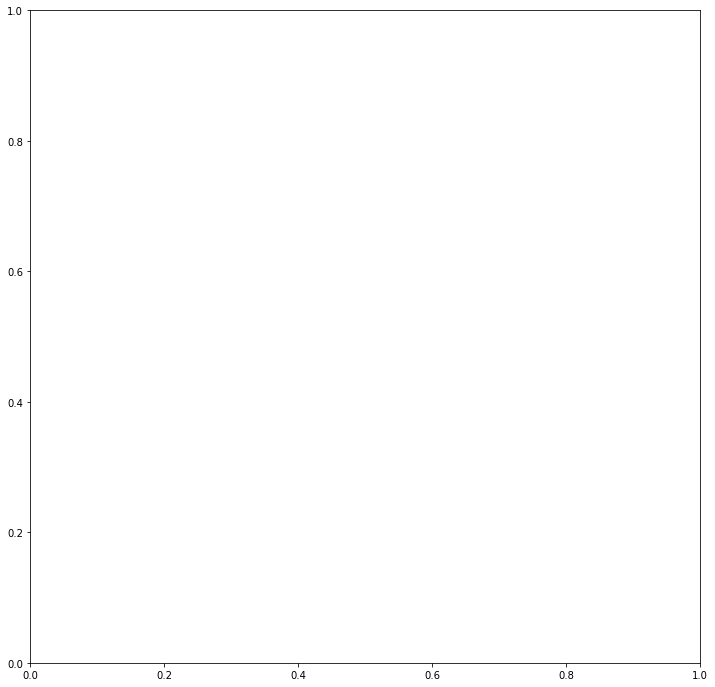

In [9]:
fig, ax = plt.subplots(figsize=(12,12))
# 名詞のNodeを描画
# Nodeを色分けしたいときは、nodelistを使ってNodeのグループ毎に描画関数を繰り返し実行する
# nodelistはグループ毎のNode番号を指定するが、それ以外の引数(posやnode_sizeなど)は全てのNodeについての値を入れる
# 指定出来る色はmatplotlibのcolor exampleを参照
# https://matplotlib.org/examples/color/named_colors.html
nx.draw_networkx_nodes(G_result, pos, 
                       nodelist=[n for n in G_result.nodes() if n in node_type["名詞"]],  
                       node_size=node_size, node_color="orange", alpha=0.6, ax=ax)
nx.draw_networkx_nodes(G_result, pos, 
                       nodelist=[n for n in G_result.nodes() if n in node_type["動詞"]], 
                       node_size=node_size, node_color="yellowgreen", alpha=0.6, ax=ax)
nx.draw_networkx_nodes(G_result, pos, 
                       nodelist=[n for n in G_result.nodes() if n in node_type["形容詞"]], 
                       node_size=node_size, node_color="tomato", alpha=0.6, ax=ax)
# edgeの色に濃淡をつけたいときは、edge_colorに数値のlistを代入してedge_cmapを使用
# Sequentialなカラーマップから好きなやつを選ぶ
# https://matplotlib.org/examples/color/colormaps_reference.html
# 色の濃淡の具合はedge_vmin, edge_vmaxで調整
nx.draw_networkx_edges(G_result, pos, alpha=0.6,
                       width=edge_width, edge_color=edge_colors, 
                       edge_vmin=0, edge_vmax=10,
                       edge_cmap=plt.cm.Blues,ax=ax)
# Nodeにラベルをつけたいときは、以下の関数を使う
# font_familyにPCに入っている日本語フォントを指定してあげると、日本語を描画してくれる
nx.draw_networkx_labels(G_result, pos, labels, font_size=10, font_family="IPAPGothic", ax=ax)

plt.show()